In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
from data import JSONDataset, get_dataloader
from codwoe_models import DefmodModel

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import tqdm

import argparse
import itertools
import json
import logging
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.__version__

'1.9.0+cu102'

In [5]:
dataset_name_dev = '/my-docker-container/codwoe/data/train-data_all/ru.dev.json'
dataset_name_train = '/my-docker-container/codwoe/data/train-data_all/ru.train.json'

In [6]:
dataset_ru_train = JSONDataset(dataset_name_train)
dataset_ru_dev = JSONDataset(dataset_name_dev, vocab=dataset_ru_train.vocab)

In [7]:
len(dataset_ru_train)

43608

In [8]:
len(dataset_ru_dev)

6375

In [9]:
DEVICE = 'cuda:0'

In [10]:
x = torch.tensor( [ [0,1,2], [3,4,6] ] )

In [11]:
x.to("cuda:0")

tensor([[0, 1, 2],
        [3, 4, 6]], device='cuda:0')

In [12]:
!nvidia-smi

Sun Jan 30 15:45:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:18:00.0 Off |                  N/A |
| 41%   29C    P8    16W / 280W |      8MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN V             Off  | 00000000:3B:00.0 Off |                  N/A |
| 28%   

In [13]:
## make dataloader
train_dataloader = get_dataloader(dataset_ru_train, batch_size=300)
dev_dataloader = get_dataloader(dataset_ru_dev, shuffle=False, batch_size=300)

In [14]:
train_step = itertools.count()

In [15]:
model = DefmodModel(dataset_ru_dev.vocab).to(DEVICE)

In [16]:
model.train()

DefmodModel(
  (embedding): Embedding(62070, 256, padding_idx=0)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_featur

In [17]:
SOURCE_ARCH = 'electra'

In [18]:
# with torch.no_grad():
#     for batch in dev_dataloader:
#             vec = batch[vec_tensor_key].to(DEVICE)
#             gls = batch["gloss_tensor"].to(DEVICE)
#             pred = model(vec, gls[:-1])
#             break
            
#     torch.argmax(pred, dim=2)[1]
#     argmax_pred = torch.argmax(pred, dim=2)        
    
    
#     dataset_ru_train.decode(argmax_pred)
    
#     batch['gloss_tensor'][1]

NameError: name 'vec_tensor_key' is not defined

In [19]:
 ## Hyperparams
EPOCHS, LEARNING_RATE, BETA1, BETA2, WEIGHT_DECAY = 200, 1.0e-4, 0.9, 0.999, 1.0e-6
optimizer = optim.AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        betas=(BETA1, BETA2),
        weight_decay=WEIGHT_DECAY,
)
criterion = nn.CrossEntropyLoss(ignore_index=model.padding_idx)

vec_tensor_key = f"{SOURCE_ARCH}_tensor"


кипящий при высокой температуре
не , бурлящий бурлящий воздуха </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq>
зоол . небольшое млекопитающее , примат из подотряда мокроносых обезьян
ботан . отряд млекопитающее из единственный из семейства теропод , из , , , , океана океана или или или и и
перен . говорить , произносить что-либо кратко , мимоходом , попутно или резко , отрывисто
включить . подготовить куда-либо заявлять что-либо </seq> , резко , стараясь , в </seq> в </seq> </seq> </seq> </seq> </seq> и и и и и и в ) ) ) </seq> глаз
результат такого действия ; документ , полученный с помощью печатающего устройства или процесса печати
результат такого действия ; новая , по путём помощью различных , , мячом , </seq> , и и </seq> </seq> и и
воен. , разг . знак различия в петлицах младших офицеров в СССР до 1943 года , имеющий форму квадрата
морск , спорт . уменьш.-ласк прицела у том , членов , душе , начала , </seq> размещённый были

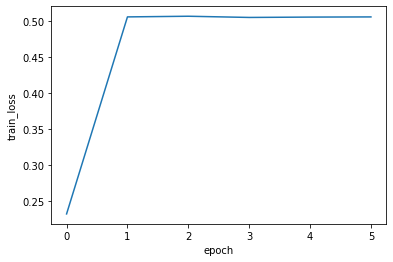

Epochs:   3%|▎         | 6/200 [05:34<2:59:58, 55.66s/it]

In [ ]:
# 4. train model
best_loss = 10000.0
patience = 0

train_loss = []
validation_loss = []
validation_accuracy = []

for epoch in tqdm.trange(EPOCHS, desc="Epochs"):
    ## train loop
    pbar = tqdm.tqdm(
        desc=f"Train {epoch}", total=len(dataset_ru_train), disable=None, leave=False
    )
    running_loss = 0.0
    
    
    for batch in train_dataloader:
        optimizer.zero_grad()
        vec = batch[vec_tensor_key].to(DEVICE)
        gls = batch["gloss_tensor"].to(DEVICE)
        pred = model(vec, gls[:-1])
        loss = criterion(pred.view(-1, pred.size(-1)), gls.view(-1))
        loss.backward()
        running_loss += loss.item()
        # keep track of the train loss for this step
        tokens = gls != model.padding_idx
        acc = (
            ((pred.argmax(-1) == gls) & tokens).float().sum() / tokens.sum()
        ).item()
        step = next(train_step)
        #summary_writer.add_scalar("defmod-train/xent", loss.item(), step)
        #summary_writer.add_scalar("defmod-train/acc", acc, step)
        optimizer.step()
        pbar.update(vec.size(0))
        
    #early stopping   
    epoch_loss = running_loss / len(train_dataloader)
    train_loss.append(epoch_loss)
    
    if best_loss - epoch_loss > 0.0001:
        best_loss = epoch_loss
        patience = 0
        #сохраняем модель
        torch.save(model, 'best_model.ckpt')
    else:
        patience += 1
    if patience == 10:
        break
        
    pbar.close()
    clear_output(wait=True)
    ## eval loop (условие выполняется - можно убрать)
    if True:
        model.eval()
        with torch.no_grad():
            sum_dev_loss = 0.0
            sum_acc = 0
            ntoks = 0
            pbar = tqdm.tqdm(
                desc=f"Eval {epoch}",
                total=len(dataset_ru_dev),
                disable=None,
                leave=False,
            )
            counter = 0
            for batch in dev_dataloader:
                vec = batch[vec_tensor_key].to(DEVICE)
                gls = batch["gloss_tensor"].to(DEVICE)
                pred = model(vec, gls[:-1])
                sum_dev_loss += F.cross_entropy(
                    pred.view(-1, pred.size(-1)),
                    gls.view(-1),
                    reduction="sum",
                    ignore_index=model.padding_idx,
                ).item()
                tokens = gls != model.padding_idx
                ntoks += tokens.sum().item()
                sum_acc += ((pred.argmax(-1) == gls) & tokens).sum().item()
                
                #Выводим оригинал с генераций
                if counter < 5:
                    counter += 1
                    
                    original_tokens = batch['gloss'][0]

                    argmax_pred = torch.argmax(pred, dim=2)
                    
                    generative_tokens = dataset_ru_train.decode(argmax_pred)[0]
                    print(original_tokens)
                    print(generative_tokens)
                    print('='*10)
                    
                pbar.update(vec.size(0))
                
            #Собираем и выводим метрики
            validation_loss.append(sum_dev_loss/ntoks)
            validation_accuracy.append(sum_acc/ntoks)
            print("validation_loss: {}".format(sum_dev_loss/ntoks))
            print("validation_accuracy: {}".format(sum_acc/ntoks))
            print("train_loss: {}".format(epoch_loss))
            
            #График train_loss
            x_list = range(0, len(train_loss))
            plt.xlabel('epoch')
            plt.ylabel('train_loss')
            plt.plot(x_list, train_loss)
            plt.show()

            # keep track of the average loss & acc on dev set for this epoch
            #summary_writer.add_scalar(
            #   "defmod-dev/xent", sum_dev_loss / ntoks, epoch
            #)
            #summary_writer.add_scalar("defmod-dev/acc", sum_acc / ntoks, epoch)
            pbar.close()
        model.train()
    



In [41]:
len(dev_dataloader)

277

In [23]:
model = torch.load('best_baseline.ckpt')
model.eval();

In [29]:
with torch.no_grad():
    for batch in dev_dataloader:
            vec = batch[vec_tensor_key].to(DEVICE)
            gls = batch["gloss_tensor"].to(DEVICE)
            pred = model(vec, gls[:-1])
            break
    

In [26]:
torch.argmax(pred, dim=2).shape

torch.Size([31, 21])

In [31]:
torch.argmax(pred, dim=2)[1]
argmax_pred = torch.argmax(pred, dim=2)

In [40]:
dataset_ru_train.decode(argmax_pred)

['не по значению прилагательного устремлённый , </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq> </seq>',
 'относящийся с ; имеющий записи , , , , , , </seq> , , , , ) ) или ) и и и и и ) )',
 'город в севере , , , , , , , , , , , , , ) ) ) в и и и и и , )',
 'перен , , , </seq> </seq> </seq> </seq> </seq> ; </seq> </seq> </seq> </seq> </seq> </seq> ) ) </seq> ) </seq> </seq> и и и ) )',
 'нареч . к органичный ; вызывая что-либо глупая </seq> свидетельствуя </seq> </seq> </seq> , , , </seq> </seq> </seq> </seq> </seq> </seq> и и и )',
 'истор . представитель престол ослабление ( , корабле от имени сторону Руси </seq> некоторых </seq> ) ) , обитающий также административной рыбе государстве до вв .',
 'предик или невозможно , </seq> , , , , , и и и и и и и и или и и и и и и и )',
 'археол . башня , , , событие , которая души умерших праведников их и храма собирают и горении </seq> , и </seq> и и и в в',
 

In [97]:
batch['gloss_tensor'][1]

tensor([1179,  764,  145,   57, 5195,  980, 2522,  240,  563, 1107,   32,    7,
        3499,  326, 5305,  765, 1249,   43,   57])

In [28]:
batch['gloss_tensor'].shape

torch.Size([31, 21])

In [30]:
pred.shape

torch.Size([38, 21, 62070])

In [32]:
argmax_pred.shape

torch.Size([38, 21])

In [34]:
dataset_ru_train.decode(batch['gloss_tensor'])

IndexError: list index out of range

In [35]:
batch['gloss_tensor']

tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2],
        [  342,  2887,   153,  3432,    33,   283, 10959,  3381,    33,  8240,
           764,   153,  3469,   606,    17,  1604,  1129,  3862,   575,   180,
            33],
        [  247,    87,     5,    10,     5,    10,     5,   254,     5,    10,
            58,     5,     5,     5, 17464,     5,     5,   249,    43,     5,
             5],
        [   10, 49790, 48719,   182,   641,   684,     6,  1608,   556,   726,
            59, 12143,  9563, 35135,     5, 57747, 60885, 58942,  6763,    12,
         21489],
        [20799,    10,     1,     5,     5,    58, 47636,    43, 35637,  2191,
           766,    10,    39,    10, 42291,    20,  6144,    10, 10913,  5977,
            10],
        [   43,  4022,     0,  1143,    12,    59,   575,  3894,    10,   937,
         58668, 48719,  8315, 34758,    24,   

In [38]:
batch['gloss'][8]

'разг . предлагать угощение , часто в виде алкогольных напитков'

In [39]:
dataset_ru_train.decode(argmax_pred)[8]

'украшать . надевать кому-либо , группа ; спешке ; напитков , , , , , , ) или или или и и и и и , ) ) ) ) </seq> глаз , , , , ,'

In [89]:
torch.max(pred[0][0])

tensor(15.5385, device='cuda:0')

In [91]:
pred[0][0][2]

tensor(15.5385, device='cuda:0')

In [75]:
tokens.shape

torch.Size([31, 19])

In [71]:
pred.shape

torch.Size([31, 19, 62070])

In [72]:
gls.shape

torch.Size([31, 19])

In [61]:
batch.keys()

dict_keys(['id', 'gloss', 'sgns', 'char', 'electra', 'gloss_tensor', 'sgns_tensor', 'char_tensor', 'electra_tensor'])

In [62]:
vec_tensor_key

'electra_tensor'

In [77]:
batch['gloss_tensor'].shape

torch.Size([31, 19])

In [80]:
batch['gloss_tensor'][5]

tensor([47002,  8664,    17,     5,    10,  3615,    39, 33404, 18933,    62,
         6429,    87,     1,  2374,    21, 22797,     1,    21,     5])

In [82]:
batch['gloss_tensor'][1]

tensor([1179,  764,  145,   57, 5195,  980, 2522,  240,  563, 1107,   32,    7,
        3499,  326, 5305,  765, 1249,   43,   57])

In [63]:
batch['electra_tensor']

tensor([[-1.1139,  0.4665,  0.6526,  ..., -0.5923,  1.1251, -0.3396],
        [-1.1330,  0.2230,  1.9625,  ..., -0.6206,  0.0260,  0.1966],
        [-0.5354,  0.0403,  0.3791,  ...,  0.2728,  0.2857, -0.1000],
        ...,
        [-0.3645,  0.7433,  1.7985,  ..., -1.0355,  0.6357, -1.1028],
        [-0.0469, -0.0821,  0.4279,  ..., -0.1163,  0.3659,  0.7288],
        [ 0.2664,  0.0864, -0.1393,  ...,  0.0560, -0.5829, -0.2289]])

In [64]:
batch['electra_tensor'].shape

torch.Size([22, 256])

In [67]:
predict = model.pred(batch['electra_tensor'][0].to(DEVICE))

RuntimeError: The expanded size of the tensor (1) must match the existing size (256) at non-singleton dimension 1.  Target sizes: [256, 1, -1].  Tensor sizes: [256, 1]

In [31]:
len(train_dataloader)

1934

In [32]:
train_loss

[7.151436775645401,
 6.238752676264577,
 5.958147824858436,
 5.758858017492442,
 5.591774598765644,
 5.4295127537282575,
 5.29616095090233,
 5.156173358412292,
 5.04054901271966,
 4.917974245585231,
 4.813481629202999,
 4.704548403050562,
 4.60346548609058,
 4.505508995352018,
 4.412848985922497,
 4.32501947460648,
 4.23581221345292,
 4.153935537096633,
 4.075283728932891,
 3.998434167490134,
 3.9231756241393065,
 3.846653335836582,
 3.7780088928394258,
 3.7053245070555096,
 3.6417088266982165,
 3.57354820723864,
 3.5088994883948548,
 3.444061639267015,
 3.3853162670086188,
 3.3337582193214867,
 3.265919085249166,
 3.216521354347868,
 3.1617410227332763,
 3.1083676389725774,
 3.0625630199231186,
 3.0147087312656944,
 2.9748769812401474,
 2.926697613041551,
 2.8872442333010384,
 2.844032263620193,
 2.809602546285079,
 2.7664496932552423,
 2.7329513519355157,
 2.699629238744063,
 2.6638330154606327,
 2.633214264584179,
 2.602581023430257,
 2.5762557029231012,
 2.544745602615124,
 2.51454

In [33]:
validation_loss

[6.458888597477621,
 6.308046812652259,
 6.297887404558993,
 6.308547057833849,
 6.341927959417087,
 6.399686267316243,
 6.417590404267417,
 6.4508496136034585,
 6.477462191179229,
 6.528707330243129,
 6.532081305405727,
 6.5874111266107604,
 6.604463251923291,
 6.652783526022134,
 6.69792735820663,
 6.711491195723858,
 6.779171882940106,
 6.796900778914951,
 6.837475140407728,
 6.867685032471273,
 6.905057720044754,
 6.937573883779002,
 6.980188961120358,
 7.001885446906018,
 7.046493828321036,
 7.050094497496036,
 7.095884136794487,
 7.110462792982845,
 7.1302215223066225,
 7.131007369580714,
 7.170580089629931,
 7.187798165789825,
 7.232146019467729,
 7.225511804399777,
 7.2567072396660235,
 7.3086941846996325,
 7.268378732237185,
 7.313570572291795,
 7.305982447075438,
 7.3468051046080705,
 7.371732570246912,
 7.369325518020234,
 7.407218750129203,
 7.420291913573409,
 7.4195712359483625,
 7.425405218173896,
 7.439525648936834,
 7.47738818875012,
 7.467899013909373,
 7.517584372253

In [34]:
validation_accuracy

[0.24389598518197783,
 0.2659666594500974,
 0.27277428976931034,
 0.2789204012412499,
 0.28432080055808134,
 0.28696687594717474,
 0.29007000072165695,
 0.2925476894950807,
 0.29539823434605855,
 0.29722643188761394,
 0.30109932404801426,
 0.30129176589449375,
 0.3018330085877174,
 0.30421447643790145,
 0.30619903297972145,
 0.3045873325154555,
 0.30784681629020233,
 0.3058983425945972,
 0.307570181135888,
 0.3104327536022708,
 0.3090616054461043,
 0.3104688364484857,
 0.3110822448341392,
 0.3090495778306993,
 0.30959082052392295,
 0.3080873685983017,
 0.31038464314065095,
 0.3128743595294797,
 0.31435375622429096,
 0.30959082052392295,
 0.3113107695268336,
 0.3123932549132809,
 0.31407712106997665,
 0.31419739722402634,
 0.31146712852709824,
 0.31176781891222244,
 0.31459430853239034,
 0.3143898390705059,
 0.31576098722667245,
 0.31684347261311974,
 0.31661494792042527,
 0.31746890861417815,
 0.31751701907579805,
 0.3186836977700801,
 0.31934521661735343,
 0.31846720069279066,
 0.3182

In [35]:
print(loss)

tensor(0.7216, device='cuda:0', grad_fn=<NllLossBackward>)


In [36]:
loss.item

<function Tensor.item>

In [37]:
loss.item()

0.7216253280639648

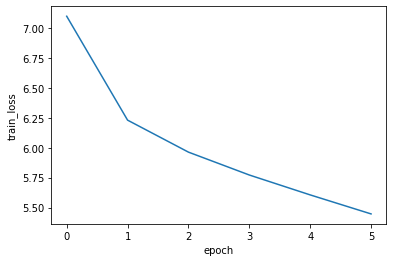

In [32]:
x_list = range(0, len(train_loss))
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.plot(x_list, train_loss)
plt.show()

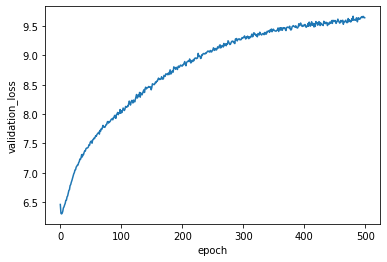

In [45]:
y_list = [6.458888597477621,
 6.308046812652259,
 6.297887404558993,
 6.308547057833849,
 6.341927959417087,
 6.399686267316243,
 6.417590404267417,
 6.4508496136034585,
 6.477462191179229,
 6.528707330243129,
 6.532081305405727,
 6.5874111266107604,
 6.604463251923291,
 6.652783526022134,
 6.69792735820663,
 6.711491195723858,
 6.779171882940106,
 6.796900778914951,
 6.837475140407728,
 6.867685032471273,
 6.905057720044754,
 6.937573883779002,
 6.980188961120358,
 7.001885446906018,
 7.046493828321036,
 7.050094497496036,
 7.095884136794487,
 7.110462792982845,
 7.1302215223066225,
 7.131007369580714,
 7.170580089629931,
 7.187798165789825,
 7.232146019467729,
 7.225511804399777,
 7.2567072396660235,
 7.3086941846996325,
 7.268378732237185,
 7.313570572291795,
 7.305982447075438,
 7.3468051046080705,
 7.371732570246912,
 7.369325518020234,
 7.407218750129203,
 7.420291913573409,
 7.4195712359483625,
 7.425405218173896,
 7.439525648936834,
 7.47738818875012,
 7.467899013909373,
 7.517584372253851,
 7.533156855679703,
 7.537876157505289,
 7.50230201393963,
 7.559074675493997,
 7.565346592416814,
 7.588485981685043,
 7.580297388193919,
 7.603115842597651,
 7.631718263022525,
 7.620225001447072,
 7.650652746851302,
 7.664329628463672,
 7.681016552970464,
 7.690212773449716,
 7.657313562667423,
 7.720789651301106,
 7.706094081170524,
 7.749318902508754,
 7.738295763303013,
 7.770136937044172,
 7.8058505422933475,
 7.778279086497442,
 7.783863860554693,
 7.772229747997496,
 7.79534152014588,
 7.8195966344488665,
 7.819900904341603,
 7.864037307196385,
 7.87324126112989,
 7.845350982496437,
 7.870667856866161,
 7.865001422171556,
 7.880631494303009,
 7.900482071288804,
 7.915778684500237,
 7.91545636290689,
 7.90146045731155,
 7.940670746709249,
 7.93540594693698,
 7.9769635722290255,
 7.968820011821361,
 7.926303259079722,
 7.990392767477722,
 8.000918591507977,
 8.026857368619913,
 7.988444472353739,
 8.015660307628815,
 8.012170460222373,
 8.076137721387994,
 8.012338070886537,
 8.053033154687126,
 8.025725599668245,
 8.066267622629526,
 8.101550441552085,
 8.080221245107673,
 8.059710064522989,
 8.083273237834536,
 8.129087828525389,
 8.115403815793876,
 8.115398982430849,
 8.133539570599213,
 8.128941362356251,
 8.178818678036334,
 8.219856214673579,
 8.19622548880041,
 8.152498918278086,
 8.197707846884416,
 8.23109926749238,
 8.228867309420554,
 8.187897953740851,
 8.236954970487238,
 8.224440549388113,
 8.206293589534697,
 8.253035028973398,
 8.29182267549771,
 8.33242927421516,
 8.271707502535195,
 8.283802368049543,
 8.326497582296609,
 8.310061396571998,
 8.367807877634117,
 8.287149076995625,
 8.35775276693002,
 8.342636655675493,
 8.32675679561445,
 8.360052171484949,
 8.388273190088192,
 8.412670146417895,
 8.366877134079534,
 8.43428047075382,
 8.457070975487062,
 8.427600999066708,
 8.439888386078186,
 8.45117975821216,
 8.45240078916199,
 8.46926490292023,
 8.459820761162943,
 8.454533034115862,
 8.463338956126078,
 8.41244707173843,
 8.452009954014574,
 8.515153171564725,
 8.503608334540793,
 8.504761605497785,
 8.500232734064443,
 8.516371021948425,
 8.544447487466378,
 8.533725438000179,
 8.558736969946278,
 8.559186061607607,
 8.589211558008673,
 8.611753198135888,
 8.586707066791075,
 8.5954558732279,
 8.589736872039843,
 8.593002990677142,
 8.635034682697881,
 8.606118261786875,
 8.592895391089426,
 8.600728258898839,
 8.65893657168891,
 8.652162206711767,
 8.641774797160844,
 8.68442876411624,
 8.680361547123915,
 8.679609621483896,
 8.669502422190256,
 8.696406873521449,
 8.671236700969331,
 8.710531929160917,
 8.752356663829842,
 8.681236474291653,
 8.689215476820717,
 8.724615225101756,
 8.738968653473687,
 8.713089700240815,
 8.802907355659688,
 8.793053339725823,
 8.788310198497,
 8.762279290908175,
 8.795083533888535,
 8.776162165989362,
 8.758179119101206,
 8.807761576145236,
 8.816950903356137,
 8.79498269139225,
 8.811874605108954,
 8.83259483194802,
 8.830528391967254,
 8.817577452263992,
 8.817459796873308,
 8.842081338675474,
 8.840608643646986,
 8.865194439558225,
 8.894188706684611,
 8.843223382194111,
 8.822942803826022,
 8.87901681207807,
 8.889458714787276,
 8.897198457404293,
 8.906713553576825,
 8.893172296835722,
 8.937387172833592,
 8.901344049903422,
 8.869875536600198,
 8.90056719507775,
 8.91228220480062,
 8.893422944588588,
 8.924488917080962,
 8.909497275568924,
 8.947873694956746,
 8.945651659080342,
 8.955681956220701,
 8.943716145316522,
 8.949349921041758,
 8.95348184079083,
 9.033285233442859,
 8.98636610184327,
 8.987349480530344,
 8.985062865961341,
 8.945916412706621,
 8.954561168047306,
 9.010127925347458,
 9.005327067861874,
 9.026423671190459,
 9.031076110515368,
 9.027609467509276,
 9.021581680933956,
 9.03828843661766,
 9.032364907973237,
 9.051725141050806,
 9.060727394942537,
 9.073778628213288,
 9.06359779299365,
 9.066256793811482,
 9.054836723476477,
 9.082722467895664,
 9.063030125370977,
 9.05717547214968,
 9.081832640183267,
 9.083043912964792,
 9.127521280804086,
 9.116288821888963,
 9.083654251313359,
 9.10721349861861,
 9.116832224326116,
 9.091016797809958,
 9.113508064956594,
 9.145084611337944,
 9.126526348734977,
 9.126008328794788,
 9.170555314239776,
 9.178495346173579,
 9.125234653021149,
 9.1534738818922,
 9.164030244789693,
 9.166004324150906,
 9.140318038869589,
 9.202313886217913,
 9.163102275793973,
 9.178371019352621,
 9.196341498322335,
 9.162739338975413,
 9.19798897477593,
 9.189246038445287,
 9.24822504726712,
 9.227325084879258,
 9.202737348722197,
 9.183319446370742,
 9.19046667917116,
 9.216637470555247,
 9.236860758081805,
 9.241248322102136,
 9.241383404284518,
 9.216515275811545,
 9.226172734492927,
 9.199958335661922,
 9.27665069573471,
 9.270221484558821,
 9.286292721643582,
 9.245449632434195,
 9.26684699221757,
 9.27517410296306,
 9.281962910401854,
 9.265574207109994,
 9.271539102705594,
 9.264634122405981,
 9.278479280517914,
 9.302709659072542,
 9.288875409796361,
 9.305305223468865,
 9.311598833264926,
 9.330490628749233,
 9.299337050817897,
 9.278296556785003,
 9.312935864514456,
 9.296501376046121,
 9.326364813103073,
 9.311570999675165,
 9.283886969521083,
 9.316184559847065,
 9.302336109997617,
 9.303899074540771,
 9.332234415687168,
 9.360935981352052,
 9.316122910977041,
 9.322544861830888,
 9.382340910883732,
 9.380850950383643,
 9.353105435157246,
 9.358378946214806,
 9.335140185968546,
 9.353380456743526,
 9.31551460684004,
 9.37082840101263,
 9.36704781845132,
 9.346097675419012,
 9.393742508874595,
 9.366908929738617,
 9.354816545507235,
 9.34557489993118,
 9.364537566142488,
 9.369802268645529,
 9.371170763737604,
 9.351695398396437,
 9.388057773616975,
 9.388781751054719,
 9.357979853873399,
 9.367351644943195,
 9.40882207149177,
 9.402360596296283,
 9.410779078451625,
 9.419715849230458,
 9.39184676758071,
 9.433670104509172,
 9.41899693566546,
 9.447501020937823,
 9.401773934379115,
 9.417501177185239,
 9.446012729797928,
 9.43574333755263,
 9.419923732291686,
 9.417490680183732,
 9.412000131011741,
 9.412014939425921,
 9.426584733469921,
 9.432626139205459,
 9.466908990816352,
 9.406246891055222,
 9.43952862941282,
 9.469190539310288,
 9.430698456899227,
 9.470887313277144,
 9.433124744574677,
 9.426020793277498,
 9.47080280687251,
 9.458175667621923,
 9.469510748876687,
 9.469511657334577,
 9.437625693866556,
 9.421581504601361,
 9.472395939925725,
 9.47974953618508,
 9.481099947092293,
 9.474969990571008,
 9.46811020485848,
 9.495930115995545,
 9.446425326044693,
 9.430810306051072,
 9.442233364386663,
 9.486896892315539,
 9.497526441314728,
 9.506483018310822,
 9.49117969976253,
 9.49101945880241,
 9.478631934037738,
 9.503705111917432,
 9.473781138163144,
 9.476113113227502,
 9.464359934325227,
 9.486112538949977,
 9.53794842964329,
 9.503132947152913,
 9.524272506041058,
 9.55012967427021,
 9.516077467087088,
 9.498510898405552,
 9.492049220596426,
 9.51650749544783,
 9.500793355724431,
 9.504535645776295,
 9.525768983946516,
 9.511537493013646,
 9.477177878729876,
 9.491764953661733,
 9.49446850231804,
 9.540778514187323,
 9.495712486374085,
 9.565451304026075,
 9.52585210389759,
 9.496679516306157,
 9.533385282736115,
 9.572285302014363,
 9.511364280376025,
 9.545866041341075,
 9.518221611600508,
 9.48267939252978,
 9.540726116538572,
 9.49229295599415,
 9.575210805652846,
 9.546109212944327,
 9.557537483258828,
 9.513044104537455,
 9.550307161431611,
 9.574678644785616,
 9.56328698220411,
 9.507146635237005,
 9.551245343879861,
 9.524124396664302,
 9.52685573596509,
 9.522404769475717,
 9.5076854597805,
 9.580293575240157,
 9.549020730552426,
 9.563743652790087,
 9.539968246831052,
 9.561711876993014,
 9.553511597980526,
 9.506581181315152,
 9.551023091400669,
 9.53368027277739,
 9.532459902937143,
 9.567876361704599,
 9.544404062078094,
 9.560854527659568,
 9.592728718614502,
 9.543192605035616,
 9.595915085293647,
 9.583514663730424,
 9.59336744709799,
 9.57499357098116,
 9.592128686399521,
 9.544035798576344,
 9.565558573265468,
 9.577573989273905,
 9.61641101112686,
 9.590304936814613,
 9.56764512008047,
 9.54903897825971,
 9.5589932791353,
 9.594978508154723,
 9.571350585103554,
 9.57729847143103,
 9.597645546714318,
 9.528741602046424,
 9.571540207977673,
 9.57118175068238,
 9.585769506865889,
 9.598410692160137,
 9.560832443507088,
 9.556284251101467,
 9.560992541316269,
 9.626635509034994,
 9.573630668319149,
 9.605048234936868,
 9.58483484941778,
 9.568580806380082,
 9.578723776157245,
 9.625394617956891,
 9.595525594342735,
 9.665800010319789,
 9.599664553447528,
 9.60701277897725,
 9.601565876893973,
 9.596233987414791,
 9.630002251037522,
 9.639807461310074,
 9.571089962299533,
 9.620193559627749,
 9.64020673350779,
 9.61595192789696,
 9.614962439234114,
 9.632285948263776,
 9.647879284744022,
 9.644346853970466,
 9.662054481386138,
 9.641652603518303,
 9.662222929666827,
 9.643212751612591,
 9.639891680311667]
x_list = range(0, len(y_list))
plt.xlabel('epoch')
plt.ylabel('validation_loss')
plt.plot(x_list, y_list)
plt.show()

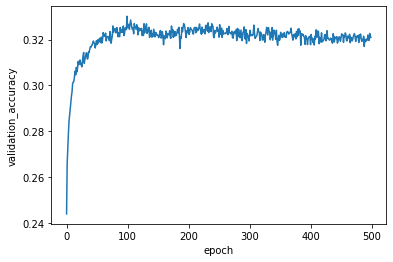

In [46]:
y_list = [0.24389598518197783,
 0.2659666594500974,
 0.27277428976931034,
 0.2789204012412499,
 0.28432080055808134,
 0.28696687594717474,
 0.29007000072165695,
 0.2925476894950807,
 0.29539823434605855,
 0.29722643188761394,
 0.30109932404801426,
 0.30129176589449375,
 0.3018330085877174,
 0.30421447643790145,
 0.30619903297972145,
 0.3045873325154555,
 0.30784681629020233,
 0.3058983425945972,
 0.307570181135888,
 0.3104327536022708,
 0.3090616054461043,
 0.3104688364484857,
 0.3110822448341392,
 0.3090495778306993,
 0.30959082052392295,
 0.3080873685983017,
 0.31038464314065095,
 0.3128743595294797,
 0.31435375622429096,
 0.30959082052392295,
 0.3113107695268336,
 0.3123932549132809,
 0.31407712106997665,
 0.31419739722402634,
 0.31146712852709824,
 0.31176781891222244,
 0.31459430853239034,
 0.3143898390705059,
 0.31576098722667245,
 0.31684347261311974,
 0.31661494792042527,
 0.31746890861417815,
 0.31751701907579805,
 0.3186836977700801,
 0.31934521661735343,
 0.31846720069279066,
 0.3182867864617161,
 0.31631425753530107,
 0.3178537923071372,
 0.3194895480022131,
 0.31780568184551733,
 0.3198624040797671,
 0.3184431454619807,
 0.31950157561761805,
 0.32052392292704046,
 0.3192971061557336,
 0.3186235596930553,
 0.3210651656202641,
 0.31847922830819564,
 0.3198624040797671,
 0.3230376945466792,
 0.3220634576988766,
 0.32137788362079334,
 0.3217146568521325,
 0.3227971422385798,
 0.3193692718481634,
 0.3212816626975536,
 0.3212696350821486,
 0.32124557985133867,
 0.32034350869596595,
 0.3194775203868081,
 0.323494743932068,
 0.32225589954535616,
 0.31838300738495584,
 0.3201149840032715,
 0.3214741045440331,
 0.3259243222438719,
 0.3230737773928941,
 0.32385557239421714,
 0.32475764354958986,
 0.32408409708691155,
 0.3229174183926295,
 0.32521469293497873,
 0.32499819585768924,
 0.3212215246205287,
 0.3230737773928941,
 0.321907098698612,
 0.32120949700512375,
 0.3252628033965986,
 0.32304972216208416,
 0.32353082677828293,
 0.3244569531644656,
 0.3231459430853239,
 0.325900267013062,
 0.3217146568521325,
 0.32265281085372016,
 0.325094416780929,
 0.3243847874720358,
 0.3242765389333911,
 0.3301580428664213,
 0.325094416780929,
 0.3259363498592769,
 0.32667003439898007,
 0.32448100839527555,
 0.3263813716292608,
 0.3285343147867504,
 0.3270068076303192,
 0.3253349690890284,
 0.32436073224122586,
 0.3250703615501191,
 0.32249645185345555,
 0.3269707247841043,
 0.32544321762767314,
 0.3254071347814582,
 0.3245050636260855,
 0.3264535373216906,
 0.3255755213971278,
 0.3220273748526617,
 0.32521469293497873,
 0.32379543431719227,
 0.32385557239421714,
 0.32463736739554017,
 0.323891655240432,
 0.3248418368574246,
 0.3217507396983474,
 0.3237713790863823,
 0.3217387120829424,
 0.3268985590916745,
 0.3228572803156046,
 0.3256597147049626,
 0.3241682903947463,
 0.32683842101464966,
 0.32266483846912514,
 0.3244208703182507,
 0.323494743932068,
 0.3253469967044334,
 0.32092083423540446,
 0.3216665463905126,
 0.32373529624016745,
 0.3240480142406966,
 0.3209929999278343,
 0.32249645185345555,
 0.32141396646700826,
 0.32448100839527555,
 0.32284525270019965,
 0.321113276081884,
 0.323109860239109,
 0.3228332250847947,
 0.3218469606215872,
 0.3219672367756369,
 0.3217507396983474,
 0.32081258569675974,
 0.3215703254672729,
 0.3236029924707128,
 0.32392773808664693,
 0.3206081162348753,
 0.32113733131269395,
 0.32348271631666303,
 0.3214741045440331,
 0.3177335161530875,
 0.3215703254672729,
 0.3214741045440331,
 0.3203675639267759,
 0.3237112410093575,
 0.32266483846912514,
 0.3207524476197349,
 0.3225445623150754,
 0.32221981669914124,
 0.3221235957759015,
 0.3238194895480022,
 0.32093286185080944,
 0.32051189531163554,
 0.32587621178225207,
 0.32335041254720837,
 0.32437275985663083,
 0.3209569170816194,
 0.32363907531692765,
 0.3213418007745784,
 0.32344663347044816,
 0.3217507396983474,
 0.3218469606215872,
 0.32308580500829903,
 0.3244689807798706,
 0.32295350123884436,
 0.3253590243198384,
 0.3212215246205287,
 0.31610978807341655,
 0.32129369031295857,
 0.3206081162348753,
 0.3252387481657886,
 0.32339852300882826,
 0.3253349690890284,
 0.3269346419378894,
 0.3264415097062856,
 0.3252387481657886,
 0.3228332250847947,
 0.32084866854297467,
 0.32379543431719227,
 0.32300161170046426,
 0.32521469293497873,
 0.3245652017031103,
 0.3221837338529263,
 0.3233744677780183,
 0.3251786100887638,
 0.324697505472565,
 0.3242765389333911,
 0.3240239590098867,
 0.32260470039210026,
 0.32237617569940585,
 0.3249741406268793,
 0.3252267205503837,
 0.3252868586274085,
 0.3229414736234394,
 0.3252387481657886,
 0.3244208703182507,
 0.32379543431719227,
 0.3244569531644656,
 0.32521469293497873,
 0.3267662553222198,
 0.3245531740877054,
 0.3239397657020519,
 0.322304010006976,
 0.32543119001226817,
 0.3228332250847947,
 0.32425248370258114,
 0.323903682855837,
 0.3241442351639364,
 0.3224723966226456,
 0.3260806812441365,
 0.3262129850135912,
 0.32476967116499483,
 0.32363907531692765,
 0.3272954704000385,
 0.32301363931586924,
 0.325094416780929,
 0.3255394385509129,
 0.3253469967044334,
 0.32344663347044816,
 0.3268865314762695,
 0.32571985278198745,
 0.32587621178225207,
 0.32098097231242934,
 0.3208246133121647,
 0.3239878761636718,
 0.32289336316181955,
 0.32357893723990283,
 0.3241081523177215,
 0.3254191623968632,
 0.32351879916287796,
 0.324300594164201,
 0.32102908277404923,
 0.32646556493709555,
 0.3221356233913064,
 0.32308580500829903,
 0.3250222510884992,
 0.3209448894662144,
 0.3240600418561016,
 0.3223521204685959,
 0.32267686608453006,
 0.32272497654614996,
 0.32253253469967047,
 0.3229895840850593,
 0.3229775564696543,
 0.3247816987803998,
 0.3221356233913064,
 0.3222679271607611,
 0.3257318803973924,
 0.3229895840850593,
 0.32295350123884436,
 0.3225084794688605,
 0.32260470039210026,
 0.3236029924707128,
 0.3208847513891896,
 0.32058406100406533,
 0.32265281085372016,
 0.3234225782396382,
 0.32255658993048036,
 0.32403598662529165,
 0.3241081523177215,
 0.319525630848428,
 0.32482980924201965,
 0.3212696350821486,
 0.3244689807798706,
 0.32300161170046426,
 0.3208366409275697,
 0.32255658993048036,
 0.3241201799331265,
 0.32000673546462677,
 0.319513603233023,
 0.3229174183926295,
 0.32336244016261334,
 0.32551538332010294,
 0.3212816626975536,
 0.32018714969570133,
 0.32431262177960596,
 0.3182988140771211,
 0.32272497654614996,
 0.32101705515864426,
 0.32164249115970267,
 0.31938129946356836,
 0.3225806451612903,
 0.3240239590098867,
 0.32160640831348775,
 0.32188304346780205,
 0.32208751292968657,
 0.32170262923672754,
 0.32248442423805057,
 0.32630920593683094,
 0.3230737773928941,
 0.3204878400808256,
 0.32089677900459457,
 0.3213418007745784,
 0.32182290539077724,
 0.32345866108585314,
 0.3247816987803998,
 0.3235428543936879,
 0.32278511462317483,
 0.3195977965408578,
 0.3232782468547786,
 0.3224002309302158,
 0.3221957614683313,
 0.31983834884895723,
 0.31977821077193236,
 0.3221356233913064,
 0.3218349330061822,
 0.31881600153953477,
 0.321919126314017,
 0.3231459430853239,
 0.3252868586274085,
 0.32348271631666303,
 0.3219672367756369,
 0.3251906377041688,
 0.323506771547473,
 0.3234346058550432,
 0.31985037646436215,
 0.3230376945466792,
 0.3210411103894542,
 0.3252387481657886,
 0.31970604507950257,
 0.3218469606215872,
 0.32413220754853145,
 0.32296552885424934,
 0.322316037622381,
 0.32010295638786657,
 0.3240600418561016,
 0.31933318900194846,
 0.3174809362295831,
 0.32000673546462677,
 0.3217988501599673,
 0.3196459070024777,
 0.320331481080561,
 0.3231459430853239,
 0.32129369031295857,
 0.3212696350821486,
 0.32093286185080944,
 0.32255658993048036,
 0.3212215246205287,
 0.3230256669312742,
 0.321125303697289,
 0.3212215246205287,
 0.32090880661999954,
 0.3232541916239686,
 0.32348271631666303,
 0.32332635731639847,
 0.3224002309302158,
 0.32260470039210026,
 0.32296552885424934,
 0.3234346058550432,
 0.3249500853960694,
 0.3225806451612903,
 0.3212816626975536,
 0.31973010031031246,
 0.32197926439104185,
 0.3222438719299512,
 0.32113733131269395,
 0.32253253469967047,
 0.3202593153881311,
 0.32348271631666303,
 0.3211613865435039,
 0.32443289793365565,
 0.3217507396983474,
 0.32470953308796996,
 0.323109860239109,
 0.32373529624016745,
 0.31750499146039307,
 0.32253253469967047,
 0.3217146568521325,
 0.3224122585456207,
 0.32208751292968657,
 0.3212816626975536,
 0.32086069615837964,
 0.3178898751533521,
 0.3216785740059176,
 0.320319453465156,
 0.3205960886194703,
 0.3178177094609223,
 0.32040364677299077,
 0.32089677900459457,
 0.32136585600538836,
 0.3209569170816194,
 0.3177335161530875,
 0.3222318443145462,
 0.3199706526184119,
 0.32057203338866036,
 0.318719780616295,
 0.3202112049265113,
 0.3176012123836328,
 0.3213899112361983,
 0.32017512208029636,
 0.3242284284717712,
 0.32119746938971877,
 0.32101705515864426,
 0.32374732385557237,
 0.32345866108585314,
 0.3181665103076664,
 0.3209929999278343,
 0.3193091337711385,
 0.3188520843857497,
 0.3229174183926295,
 0.31893627769358446,
 0.31934521661735343,
 0.319525630848428,
 0.32018714969570133,
 0.32185898823699216,
 0.32221981669914124,
 0.31942940992518826,
 0.3196459070024777,
 0.32384354477881216,
 0.32051189531163554,
 0.3205960886194703,
 0.3201510668494864,
 0.3197180726949075,
 0.3199706526184119,
 0.32062014385028026,
 0.32022323254191626,
 0.3190445262322292,
 0.3183950350003608,
 0.32253253469967047,
 0.3213418007745784,
 0.31887613961655964,
 0.321113276081884,
 0.3205600057732554,
 0.32040364677299077,
 0.3212816626975536,
 0.31843111784657574,
 0.3191648023862789,
 0.32053595054244544,
 0.3212215246205287,
 0.32057203338866036,
 0.31922494046330374,
 0.32098097231242934,
 0.3224723966226456,
 0.32208751292968657,
 0.3221235957759015,
 0.318719780616295,
 0.3216184359288927,
 0.32113733131269395,
 0.3229053907772245,
 0.3219672367756369,
 0.31945346515599815,
 0.31945346515599815,
 0.321522215005653,
 0.32119746938971877,
 0.32058406100406533,
 0.32229198239157103,
 0.31859950446224533,
 0.3210411103894542,
 0.32074042000432995,
 0.31933318900194846,
 0.319910514541387,
 0.32132977315917344,
 0.32188304346780205,
 0.3225806451612903,
 0.32119746938971877,
 0.319140747155469,
 0.32137788362079334,
 0.32092083423540446,
 0.3216184359288927,
 0.3217146568521325,
 0.31870775300089005,
 0.32208751292968657,
 0.32074042000432995,
 0.32238820331481083,
 0.3202713430035361,
 0.31922494046330374,
 0.3200428183108417,
 0.3194895480022131,
 0.3214500493132232,
 0.3169757763825744,
 0.3201510668494864,
 0.31905655384763415,
 0.31934521661735343,
 0.32012701161867646,
 0.3198022660027423,
 0.32197926439104185,
 0.3197180726949075,
 0.3195617136946429,
 0.32266483846912514,
 0.3207885304659498,
 0.32102908277404923]
x_list = range(0, len(y_list))
plt.xlabel('epoch')
plt.ylabel('validation_accuracy')
plt.plot(x_list, y_list)
plt.show()